In [1]:
import strategy_development.cnn.cnn2.prepare_data as prep
final_data = prep.prepare_2H_data()

rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']


In [2]:
import pickle
data_path = '/workspaces/PycharmProjects/strategy_development/cnn/cnn2/model_output'
loss_list = []
val_loss_list = []
accuracy_list = []
val_accuracy_list = []
for i in train_start_index_list:
    with open(data_path + '/cnn2_' + str(i) + '_history.pickle', 'rb') as input_file:
        history_output = pickle.load(input_file)
        loss_list.append(history_output.history["loss"])
        val_loss_list.append(history_output.history["val_loss"])
        accuracy_list.append(history_output.history["categorical_accuracy"])
        val_accuracy_list.append(history_output.history["val_categorical_accuracy"])
        

2023-12-17 07:38:15.725975: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 07:38:15.726033: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 07:38:15.726074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 07:38:15.734012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-17 07:38:17.148777: I tensorflow/compiler/

In [14]:
history_output.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

In [3]:
import numpy as np
avg_loss = np.mean(np.array(loss_list),0)
avg_val_loss = np.mean(np.array(val_loss_list),0)

avg_accuracy = np.mean(np.array(accuracy_list),0)
avg_val_accuracy = np.mean(np.array(val_accuracy_list),0)

In [9]:
np.array(loss_list).shape

(146, 200)

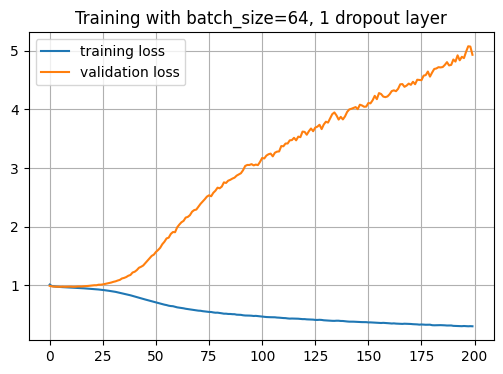

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(range(200),avg_loss,range(200),avg_val_loss)   # range(len(final_data))
plt.legend(['training loss', 'validation loss'])
plt.title('Training with batch_size=64, 1 dropout layer')
plt.grid()
plt.show()

# original batch size: 256

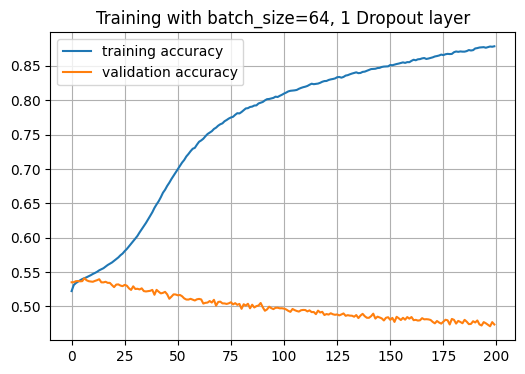

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(6,4))
plt.plot(range(200),avg_accuracy,range(200),avg_val_accuracy)   # range(len(final_data))
plt.legend(['training accuracy', 'validation accuracy'])
plt.title('Training with batch_size=64, 1 Dropout layer')
plt.grid()
plt.show()


In [45]:
# In sample profitability

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import run_cnn as rc
model = rc.create_model_cnn()

rolling_indices_output = prep.prepare_rolling_simulation_indices(entire_data=final_data)
feature_data = prep.get_features(df=final_data)

train_start_index_list = rolling_indices_output['train_start_index_list']
train_end_index_list = rolling_indices_output['train_end_index_list']

test_start_index_list = rolling_indices_output['test_start_index_list']
test_end_index_list = rolling_indices_output['test_end_index_list']

for i in range(len(train_start_index_list)):

    train_start_index = train_start_index_list[i]
    train_end_index = train_end_index_list[i]

    test_start_index = test_start_index_list[i]
    test_end_index = test_end_index_list[i]

    x_train_frame_i = feature_data.iloc[train_start_index:train_end_index, :]
    final_data_i = final_data.iloc[train_start_index:train_end_index, :]
    y_train_i = np.array(final_data['label'].iloc[train_start_index:train_end_index])

    scaler_i = StandardScaler()
    x_train_i = scaler_i.fit_transform(x_train_frame_i)
    
    x_train_i = prep.reshape_data(x_train_i)
    
    model.load_weights(data_path + '/cnn2_' + str(train_start_index) + '_weights.h5')

    output = model(x_train_i)
    pred = model.predict(x_train_i)
    pred_classes = np.argmax(pred, axis=1)
    
    break
    
    
    

    

195/195 [==============================] - 1s 5ms/step


In [47]:
final_data_i['pred'] = pred_classes
cnn_data_select = final_data_i

current_position = 0
pnl_list = []

decision_str = 'pred'

for i in range(len(cnn_data_select)):

    if current_position == 0 and cnn_data_select[decision_str].iloc[i]==2:
        current_position = 1
        pnl = cnn_data_select['percent_diff1'].iloc[i]
    elif current_position == 1 and cnn_data_select[decision_str].iloc[i]!=0:
        pnl += cnn_data_select['percent_diff1'].iloc[i]
    elif current_position ==1 and cnn_data_select[decision_str].iloc[i]==0:
        current_position = 0
        pnl_list.append(pnl)

/tmp/ipykernel_628/3358415181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_i['pred'] = pred_classes


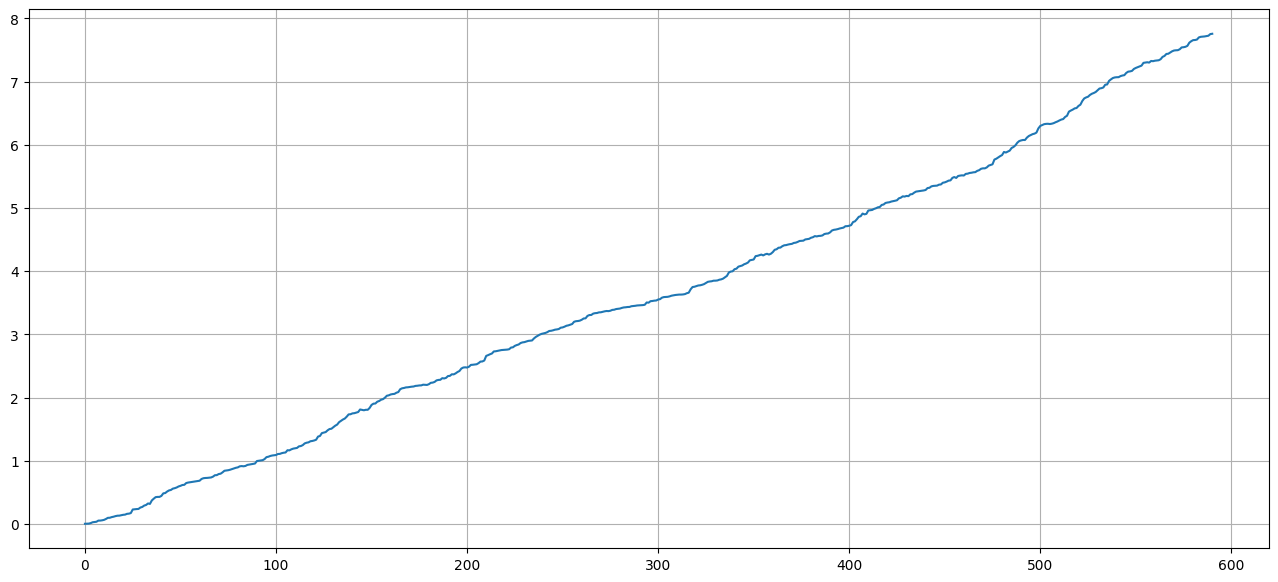

In [49]:
import numpy as np
np.nancumsum(pnl_list)

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(16,7))
plt.plot(range(len(pnl_list)),np.nancumsum(pnl_list))   # range(len(final_data))
plt.grid()
plt.show()

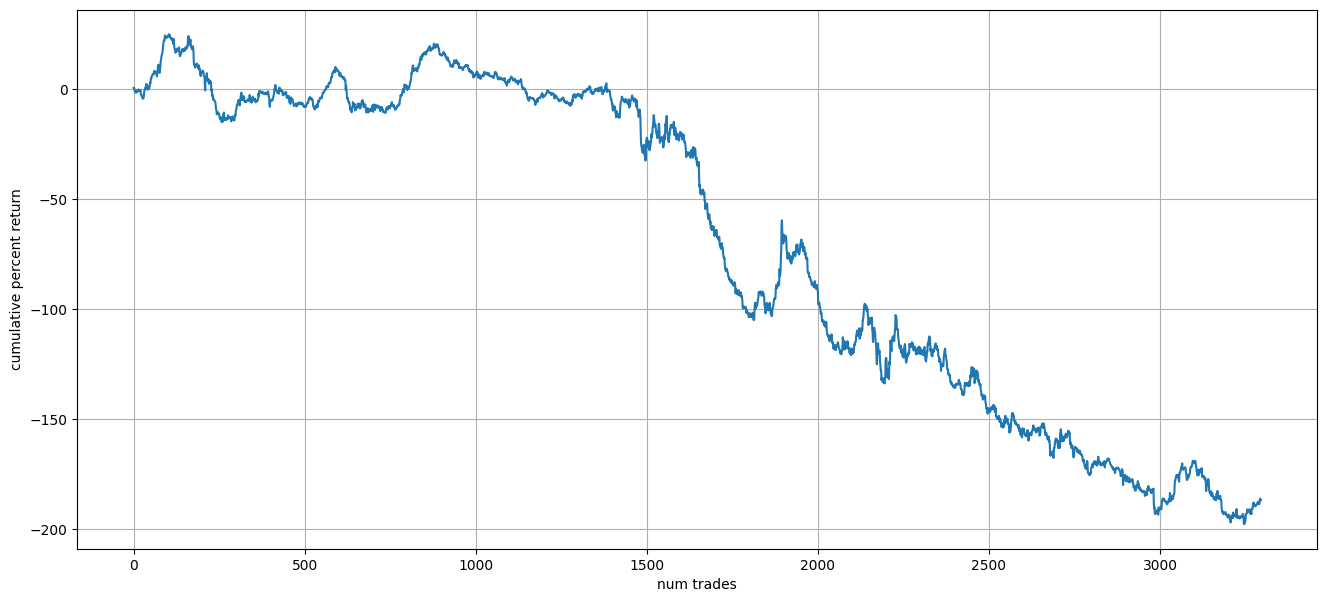

In [19]:
# Out of sample results

import pandas as pd

data_path = "/workspaces/PycharmProjects"
cnn_data_final = pd.read_pickle(data_path + '/cnn_data_final.pkl')
cnn_data_final

cnn_data_select = cnn_data_final[~cnn_data_final['predicted'].isna()]

current_position = 0
pnl_list = []

decision_str = 'predicted'

for i in range(len(cnn_data_select)):

    if current_position == 0 and cnn_data_select[decision_str].iloc[i]==2:
        current_position = 1
        pnl = cnn_data_select['percent_diff1'].iloc[i]
    elif current_position == 0 and cnn_data_select[decision_str].iloc[i]==0:
        current_position = -1
        pnl = cnn_data_select['percent_diff1'].iloc[i]
    elif (current_position == 1 and cnn_data_select[decision_str].iloc[i]!=0) or (current_position == -1 and cnn_data_select[decision_str].iloc[i]!=2):
        pnl += cnn_data_select['percent_diff1'].iloc[i]
    elif (current_position ==1 and cnn_data_select[decision_str].iloc[i]==0) or (current_position ==-1 and cnn_data_select[decision_str].iloc[i]==2):
        pnl_list.append(pnl*current_position)
        current_position = -current_position
        pnl = cnn_data_select['percent_diff1'].iloc[i]
        

np.nancumsum(pnl_list)

%matplotlib inline
import matplotlib.pyplot as plt
#trade_data=big_data
plt.figure(figsize=(16,7))
plt.plot(range(len(pnl_list)),100*np.nancumsum(pnl_list))   # range(len(final_data))
plt.ylabel('cumulative percent return')
plt.xlabel('num trades')
plt.grid()
plt.show()